In [2]:

# Default locations if parameter not passed
benchmark_data_path = "pkl/big-matrix-coaraci-345430.pkl"


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from rich import print as rprint
import seaborn as sns
import os
from scipy.stats import bootstrap

benchmark_data = pickle.load(open(benchmark_data_path, "rb"))

df = pd.DataFrame(benchmark_data["dataframe"])


rprint(df.columns)
rprint(df.head())
rprint(df.tail())

Index(['name', 'full_output', 'simu_rr', 'hosts', 'node_count',
       'biggest_matrix', 'time'],
      dtype='object')

name                                        full_output  \
0             big-matrix                                                NaN   
1  simulator-matrix-feed  Time Simulation (microseconds) : 8167 \nDistan...   
2  simulator-matrix-feed  Time Simulation (microseconds) : 9148 \nDistan...   
3  simulator-matrix-feed  Time Simulation (microseconds) : 11831 \nDista...   
4  simulator-matrix-feed  Time Simulation (microseconds) : 10395 \nDista...   

   simu_rr                                              hosts  node_count  \
0      NaN  r2n48,r2n49,r2n50,r3n06,r3n07,r3n08,r3n09,r3n1...        10.0   
1      2.0  r2n48,r2n49,r2n50,r3n06,r3n07,r3n08,r3n09,r3n1...         NaN   
2      3.0  r2n48,r2n49,r2n50,r3n06,r3n07,r3n08,r3n09,r3n1...         NaN   
3      4.0  r2n48,r2n49,r2n50,r3n06,r3n07,r3n08,r3n09,r3n1...         NaN   
4      5.0  r2n48,r2n49,r2n50,r3n06,r3n07,r3n08,r3n09,r3n1...         NaN   

   biggest_matrix       time  
0             NaN  35.966669  
1            10.0   0.787066  
2            10.0   0.490982  
3            10.0   0.540966  
4            10.0   0.604206

name                                        full_output  \
4  simulator-matrix-feed  Time Simulation (microseconds) : 10395 \nDista...   
5  simulator-matrix-feed  Time Simulation (microseconds) : 11001 \nDista...   
6  simulator-matrix-feed  Time Simulation (microseconds) : 13361 \nDista...   
7  simulator-matrix-feed  Time Simulation (microseconds) : 11298 \nDista...   
8  simulator-matrix-feed  Time Simulation (microseconds) : 11713 \nDista...   

   simu_rr                                              hosts  node_count  \
4      5.0  r2n48,r2n49,r2n50,r3n06,r3n07,r3n08,r3n09,r3n1...         NaN   
5      6.0  r2n48,r2n49,r2n50,r3n06,r3n07,r3n08,r3n09,r3n1...         NaN   
6      7.0  r2n48,r2n49,r2n50,r3n06,r3n07,r3n08,r3n09,r3n1...         NaN   
7      8.0  r2n48,r2n49,r2n50,r3n06,r3n07,r3n08,r3n09,r3n1...         NaN   
8      9.0  r2n48,r2n49,r2n50,r3n06,r3n07,r3n08,r3n09,r3n1...         NaN   

   biggest_matrix      time  
4            10.0  0.604206  
5            10.0  0.662863  
6            10.0  0.731330  
7            10.0  0.769783  
8            10.0  0.835308

In [4]:
sns.set_theme()

colors = [
    "#7f7f7f",  # grey
    "#621dac",  # main purple
    "#c5702d",  # orange
    "#000000",  # black,
    "#099892",  # teal
    "#ffd400",  # yellow
    "#7e57c4",  # pink/purple,
]
colors_backup = colors.copy()

In [5]:
def calculate_bootstrap_error(data):
    n_runs = benchmark_data["config"].metadata.runs
    if n_runs < 2:
        return 0
    res = bootstrap(
        (data,), np.mean, confidence_level=0.95, n_resamples=1000, method="basic"
    )
    return res.standard_error

In [6]:
bench_names = df["name"].unique()
run_metadata = benchmark_data["config"].applications

max_node_count = 0

for bench in bench_names:
    bench_metadata = run_metadata[bench]
    n_runs = benchmark_data["config"].metadata.runs
    print(f"Benchmark: {bench} - Runs: {n_runs}")
    # print(bench_metadata)
    df_bench = df[df["name"] == bench]
    for idx, row in df_bench.iterrows():
        print(f"--- Row {idx} ---")
        if "node_count" in row:
            node_count = row["node_count"]
            if node_count > max_node_count:
                max_node_count = node_count
        for col, val in row.items():
            print(f"{col}: {val}")   # printing val directly never truncates
        print()

max_node_count = int(max_node_count)
print(f"Max node count: {max_node_count}")

Benchmark: big-matrix - Runs: 1
--- Row 0 ---
name: big-matrix
full_output: nan
simu_rr: nan
hosts: r2n48,r2n49,r2n50,r3n06,r3n07,r3n08,r3n09,r3n10,r3n11,r3n12
node_count: 10.0
biggest_matrix: nan
time: 35.9666685750708

Benchmark: simulator-matrix-feed - Runs: 1
--- Row 1 ---
name: simulator-matrix-feed
full_output: Time Simulation (microseconds) : 8167 
Distance : 0.312848


simu_rr: 2.0
hosts: r2n48,r2n49,r2n50,r3n06,r3n07,r3n08,r3n09,r3n10,r3n11,r3n12
node_count: nan
biggest_matrix: 10.0
time: 0.787066260818392

--- Row 2 ---
name: simulator-matrix-feed
full_output: Time Simulation (microseconds) : 9148 
Distance : 0.273628


simu_rr: 3.0
hosts: r2n48,r2n49,r2n50,r3n06,r3n07,r3n08,r3n09,r3n10,r3n11,r3n12
node_count: nan
biggest_matrix: 10.0
time: 0.490982451941818

--- Row 3 ---
name: simulator-matrix-feed
full_output: Time Simulation (microseconds) : 11831 
Distance : 0.242508


simu_rr: 4.0
hosts: r2n48,r2n49,r2n50,r3n06,r3n07,r3n08,r3n09,r3n10,r3n11,r3n12
node_count: nan
biggest

# Experiment 1
x-axis: SIM_RR
y_axis: distance 

In [7]:
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def extract_distance(text):
    matches = re.findall(
        r"Distance\s*:\s*([-+]?(?:\d*\.\d+|\d+)(?:[eE][-+]?\d+)?)",
        str(text)
    )
    return float(matches[-1]) if matches else np.nan

In [8]:
df_dist = df[df["name"] == "simulator-matrix-feed"].copy()
df_dist["distance"] = df_dist["full_output"].apply(extract_distance)
df_dist = df_dist[["simu_rr", "distance"]]

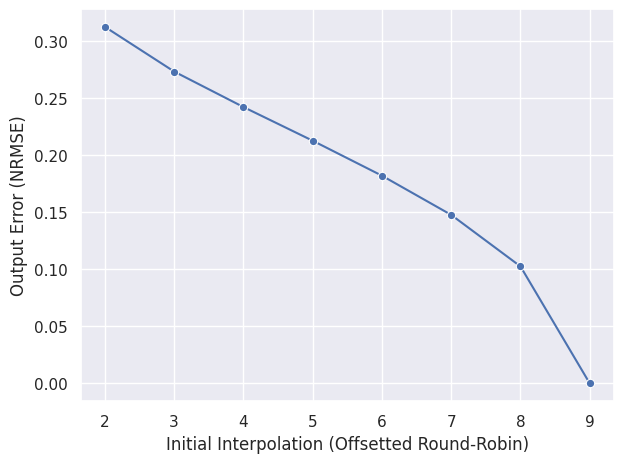

In [9]:
plt.figure()
sns.lineplot(
  data=df_dist,
  x="simu_rr",
  y="distance",
  marker="o",
  errorbar="ci",
)

plt.xlabel("Initial Interpolation (Offsetted Round-Robin)")
plt.ylabel("Output Error (NRMSE)")
#plt.title(f"Simulation Distance per Simulation RR using Matrix trace for {max_node_count-1} workers")
plt.grid(True)
plt.xticks(sorted(df_dist["simu_rr"].unique()))
plt.tight_layout()
plt.savefig("figs/simulator-matrix-feed-distance.pdf")
plt.show()